<a href="https://colab.research.google.com/github/Musavirov/my_rip/blob/master/neu.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import xgboost as xgb
import pandas as pd
import numpy as np
from geopy.distance import geodesic 
import math
from sklearn.metrics import mean_absolute_error, r2_score, median_absolute_error
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina' 
import warnings
warnings.filterwarnings('ignore')

In [0]:
#Вычисляет азимут по двум заданным точкам, код взят отсюда: https://pastebin.com/PHeWmiEN
def get_azimuth(latitude, longitude):
 
    rad = 6372795

    llat1 = city_center_coordinates[0]
    llong1 = city_center_coordinates[1]
    llat2 = latitude
    llong2 = longitude

    lat1 = llat1*math.pi/180.
    lat2 = llat2*math.pi/180.
    long1 = llong1*math.pi/180.
    long2 = llong2*math.pi/180.

    cl1 = math.cos(lat1)
    cl2 = math.cos(lat2)
    sl1 = math.sin(lat1)
    sl2 = math.sin(lat2)
    delta = long2 - long1
    cdelta = math.cos(delta)
    sdelta = math.sin(delta)

    y = math.sqrt(math.pow(cl2*sdelta,2)+math.pow(cl1*sl2-sl1*cl2*cdelta,2))
    x = sl1*sl2+cl1*cl2*cdelta
    ad = math.atan2(y,x)

    x = (cl1*sl2) - (sl1*cl2*cdelta)
    y = sdelta*cl2
    z = math.degrees(math.atan(-y/x))

    if (x < 0):
        z = z+180.

    z2 = (z+180.) % 360. - 180.
    z2 = - math.radians(z2)
    anglerad2 = z2 - ((2*math.pi)*math.floor((z2/(2*math.pi))) )
    angledeg = (anglerad2*180.)/math.pi
    
    return round(angledeg, 2)

#Вычисляет среднюю абсолютную процентную ошибку
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

#Вычисляет медианную абсолютную процентную ошибку
def median_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.median(np.abs((y_true - y_pred) / y_true)) * 100

#Печатает рассчитанные значения коэффициента детерминации, средней и медианной абсолютных ошибок
def print_metrics(prediction, val_y):
    val_mae = mean_absolute_error(val_y, prediction)
    median_AE = median_absolute_error(val_y, prediction)
    r2 = r2_score(val_y, prediction)

    print('')
    print('R\u00b2: {:.2}'.format(r2))
    print('')
    print('Средняя абсолютная ошибка: {:.3} %'.format(mean_absolute_percentage_error(val_y, prediction)))
    print('Медианная абсолютная ошибка: {:.3} %'.format(median_absolute_percentage_error(val_y, prediction)))

In [0]:
#При помощи библиотеки pandas считываем csv-файл и преобразуем его в формат датафрейма (таблицы)
file_path = 'https://raw.githubusercontent.com/maxbobkov/ml_moscow_flats/master/moscow_dataset_2020.csv'
df = pd.read_csv(file_path)

#Выводим 5 первых строк датафрейма
df.head(5)

,wallsMaterial,floorNumber,floorsTotal,totalArea,kitchenArea,latitude,longitude,price
0,brick,1,5.0,18.0,3.0,55.723379,37.628577,5600000
1,brick,1,5.0,15.0,3.0,55.725980,37.671031,4650000
2,brick,1,5.0,11.9,1.5,55.735976,37.657817,2990000
3,brick,1,7.0,18.4,3.0,55.786698,37.595321,4390000
4,brick,2,5.0,17.6,2.0,55.767894,37.665920,4890000


In [0]:
#Создаем новый столбец Стоимость 1 кв.м путем построчного деления стоимостей квартир на их общие площади
df['priceMetr'] = df['price']/df['totalArea']

#Задаем широту и долготу центра города и рассчитываем для каждой квартиры расстояние от центра и азимут 
city_center_coordinates = [55.7522, 37.6156]
df['distance'] = list(map(lambda x, y: geodesic(city_center_coordinates, [x, y]).meters, df['latitude'], df['longitude']))
df['azimuth'] = list(map(lambda x, y: get_azimuth(x, y), df['latitude'], df['longitude']))

#Выбираем из датафрейма только те квартиры, которые расположены не дальше 40 км от центра города с панельными стенами
df = df.loc[(df['distance'] < 40000)] 

#Округляем значения стоблцов Стоимости метра, расстояния и азимута
df['priceMetr'] = df['priceMetr'].round(0)
df['distance'] = df['distance'].round(0)
df['azimuth'] = df['azimuth'].round(0)

#Выводим сводную информацию о датафрейме и его столбцах (признаках)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 63682 entries, 0 to 63944
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   wallsMaterial  63682 non-null  object 
 1   floorNumber    63682 non-null  int64  
 2   floorsTotal    63682 non-null  float64
 3   totalArea      63682 non-null  float64
 4   kitchenArea    63682 non-null  float64
 5   latitude       63682 non-null  float64
 6   longitude      63682 non-null  float64
 7   price          63682 non-null  int64  
 8   priceMetr      63682 non-null  float64
 9   distance       63682 non-null  float64
 10  azimuth        63682 non-null  float64
dtypes: float64(8), int64(2), object(1)
memory usage: 5.8+ MB


In [0]:
#Вычисляем строки со значениями-выбросами 
first_quartile = df.quantile(q=0.25)
third_quartile = df.quantile(q=0.75)
IQR = third_quartile - first_quartile
outliers = df[(df > (third_quartile + 1.5 * IQR)) | (df < (first_quartile - 1.5 * IQR))].count(axis=1)
outliers.sort_values(axis=0, ascending=False, inplace=True)

#Удаляем из датафрейма 3000 строк, подходящих под критерии выбросов
outliers = outliers.head(3000)
df.drop(outliers.index, inplace=True)

In [0]:
#Вычисляем столбцы с категорийными признаками, затем заменяем их на числа
categorical_columns = df.columns[df.dtypes == 'object']
labelencoder = LabelEncoder()
for column in categorical_columns:
    df[column] = labelencoder.fit_transform(df[column])
    print(dict(enumerate(labelencoder.classes_)))

#Выводим сводную информацию о датафрейме и его столбцах (признаках), чтобы убедиться, что теперь они все содержат цифровые значения
df.info()

{0: 'None', 1: 'block', 2: 'brick', 3: 'monolith', 4: 'monolithBrick', 5: 'old', 6: 'panel', 7: 'stalin', 8: 'wood'}
<class 'pandas.core.frame.DataFrame'>
Int64Index: 60682 entries, 0 to 63942
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   wallsMaterial  60682 non-null  int64  
 1   floorNumber    60682 non-null  int64  
 2   floorsTotal    60682 non-null  float64
 3   totalArea      60682 non-null  float64
 4   kitchenArea    60682 non-null  float64
 5   latitude       60682 non-null  float64
 6   longitude      60682 non-null  float64
 7   price          60682 non-null  int64  
 8   priceMetr      60682 non-null  float64
 9   distance       60682 non-null  float64
 10  azimuth        60682 non-null  float64
dtypes: float64(8), int64(3)
memory usage: 5.6 MB


In [0]:
#Назначаем целевой переменной цену 1 кв. метра, а можно и цену всей квартиры, тогда будет y = df['price']
y = df['priceMetr']

#Создаем список признаков, на основании которых будем строить модели
features = [
            'wallsMaterial', 
            'floorNumber', 
            'floorsTotal', 
            'totalArea', 
            'kitchenArea',
            'distance',
            'azimuth'
           ]

#Создаем датафрейм, состоящий из признаков, выбранных ранее
X = df[features]

#Проводим случайное разбиение данных на выборки для обучения (train) и валидации (val), по умолчанию в пропорции 0.75/0.25
train_X, val_X, train_y, val_y = train_test_split(X, y, random_state=1)

In [0]:
#Создаем регрессионную модель случайного леса 
rf_model = RandomForestRegressor(n_estimators=2000, 
                                 n_jobs=-1,  
                                 bootstrap=False,
                                 criterion='mse',
                                 max_features=3,
                                 random_state=1,
                                 max_depth=55,
                                 min_samples_split=5
                                 )

#Проводим подгонку модели на обучающей выборке 
rf_model.fit(train_X, train_y)

#Вычисляем предсказанные значения цен на основе валидационной выборки
rf_prediction = rf_model.predict(val_X).round(0)

#Вычисляем и печатаем величины ошибок при сравнении известных цен квартир из валидационной выборки с предсказанными моделью
print_metrics(rf_prediction, val_y)


R²: 0.82

Средняя абсолютная ошибка: 8.03 %
Медианная абсолютная ошибка: 5.37 %


In [0]:
#Создаем регрессионную модель XGBoost
xgb_model = xgb.XGBRegressor(objective ='reg:gamma', 
                             learning_rate = 0.01,
                             max_depth = 45, 
                             n_estimators = 2000,
                             nthread = -1,
                             eval_metric = 'gamma-nloglik', 
                             )

#Проводим подгонку модели на обучающей выборке 
xgb_model.fit(train_X, train_y)

#Вычисляем предсказанные значения цен на основе валидационной выборки
xgb_prediction = xgb_model.predict(val_X).round(0)

#Вычисляем и печатаем величины ошибок при сравнении известных цен квартир из валидационной выборки с предсказанными моделью
print_metrics(xgb_prediction, val_y)


R²: 0.8

Средняя абсолютная ошибка: 7.78 %
Медианная абсолютная ошибка: 5.17 %


In [0]:
#Усредняем предсказания обоих моделей
prediction = rf_prediction * 0.5 + xgb_prediction * 0.5 

#Вычисляем и печатаем величины ошибок для усредненного предсказания
print_metrics(prediction, val_y)


R²: 0.82

Средняя абсолютная ошибка: 7.72 %
Медианная абсолютная ошибка: 5.21 %


Рейтинг важности признаков:
1. distance (0.528668)
2. azimuth (0.137755)
3. wallsMaterial (0.097887)
4. totalArea (0.075955)
5. kitchenArea (0.065117)
6. floorsTotal (0.063342)
7. floorNumber (0.031277)


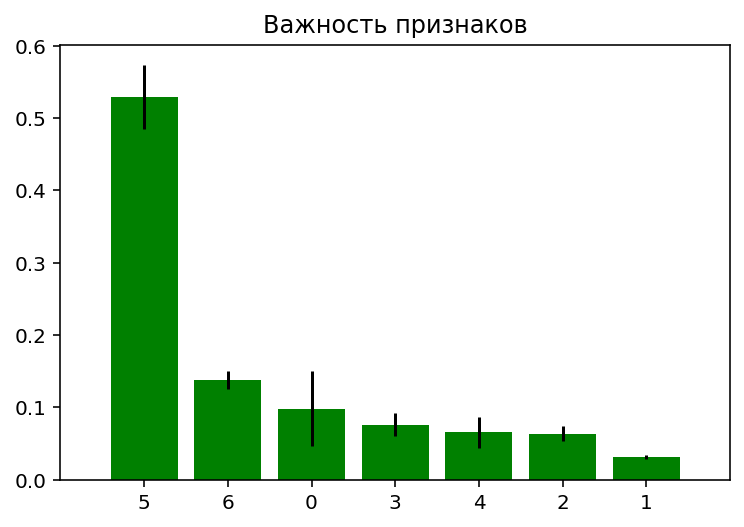

In [0]:
#Рассчитываем важность признаков в модели Random forest
importances = rf_model.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf_model.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

#Печатаем рейтинг признаков
print("Рейтинг важности признаков:")
for f in range(X.shape[1]):
    print("%d. %s (%f)" % (f + 1, features[indices[f]], importances[indices[f]]))

#Строим столбчатую диаграмму важности признаков
plt.figure()
plt.title("Важность признаков")
plt.bar(range(X.shape[1]), importances[indices], color="g", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()

In [0]:
#Создаем датафрейм с параметрами квартиры https://www.cian.ru/sale/flat/224266404/, цена предложения 11 700 000 рублей
flat = pd.DataFrame({
                     'wallsMaterial':[6], 
                     'floorNumber':[4],
                     'floorsTotal':[17],
                     'totalArea':[51.2],
                     'kitchenArea':[9.7],
                     'latitude':[55.858817],
                     'longitude':[37.638755]
                     })

#Рассчитываем недостающие параметры квартиры - расстояние от центра города и азимут
flat['distance'] = list(map(lambda x, y: geodesic(city_center_coordinates, [x, y]).meters, flat['latitude'], flat['longitude']))
flat['azimuth'] = list(map(lambda x, y: get_azimuth(x, y), flat['latitude'], flat['longitude']))
flat['distance'] = flat['distance'].round(0)
flat['azimuth'] = flat['azimuth'].round(0)

#Удаляем ненужные столбцы с широтой и долготой
flat = flat.drop('latitude', axis=1)
flat = flat.drop('longitude', axis=1)

#Вычисляем предсказанное значение стоимости по двум моделям
rf_prediction_flat = rf_model.predict(flat).round(0)
xgb_prediction_flat = xgb_model.predict(flat).round(0)

#Усредняем полученные знаечения и умножаем на общую площадь квартиры
price = (rf_prediction_flat * 0.5 + xgb_prediction_flat * 0.5)*flat['totalArea'][0]

#Печатаем предсказанное значение цены предложения
print(f'Предсказанная моделью цена предложения: {int(price[0].round(-3))} рублей')

Предсказанная моделью цена предложения: 11683000 рублей
